In [ ]:
import zipfile
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image

zip_file_name = "B_23.zip"  # Nama file yang kamu upload manual
extract_folder = zip_file_name.replace('.zip', '')  # Misalnya jadi 'B_23'

# Ekstrak file ZIP
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("✅ Berhasil diekstrak ke folder:", extract_folder)

✅ Berhasil diekstrak ke folder: B_23


In [ ]:
image_files = []
for root, dirs, files in os.walk(extract_folder):
    for file in files:
        if file.endswith('.jpg') or file.endswith('.png'):
            image_files.append(os.path.join(root, file))

print(f"🖼️ Jumlah gambar ditemukan: {len(image_files)}")

🖼️ Jumlah gambar ditemukan: 1074


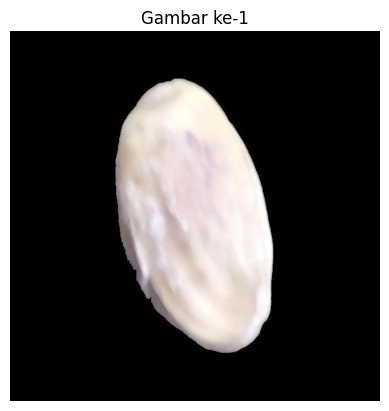

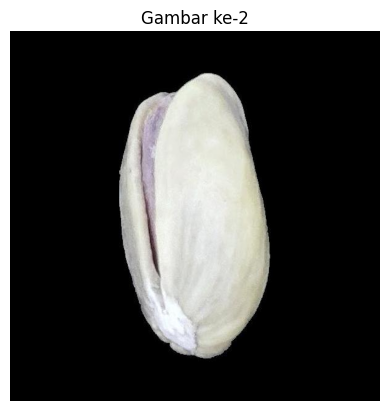

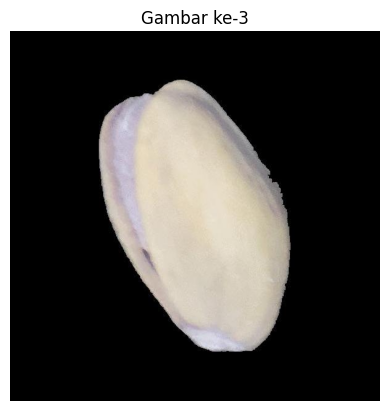

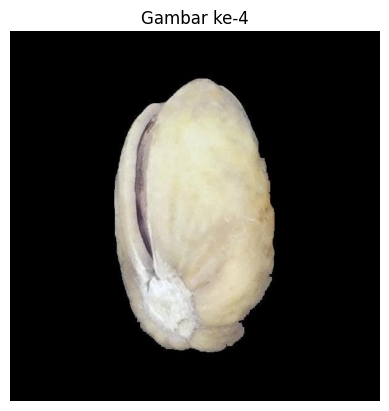

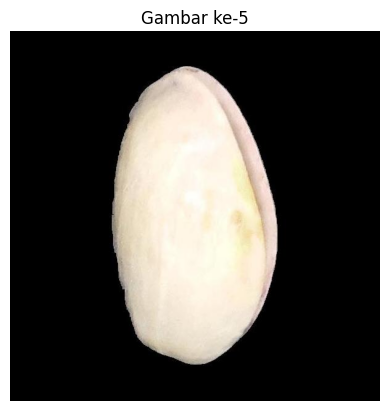

In [ ]:
for i in range(5):  #tampilin 5 gambar pertama
    img = cv2.imread(image_files[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"Gambar ke-{i+1}")
    plt.axis('off')
    plt.show()

# a. Untuk mengenali data, anda perlu melakukan EDA kemudian menjelaskan EDA apa yang anda lakukan dan informasi apa yang anda peroleh dengan EDA tersebut

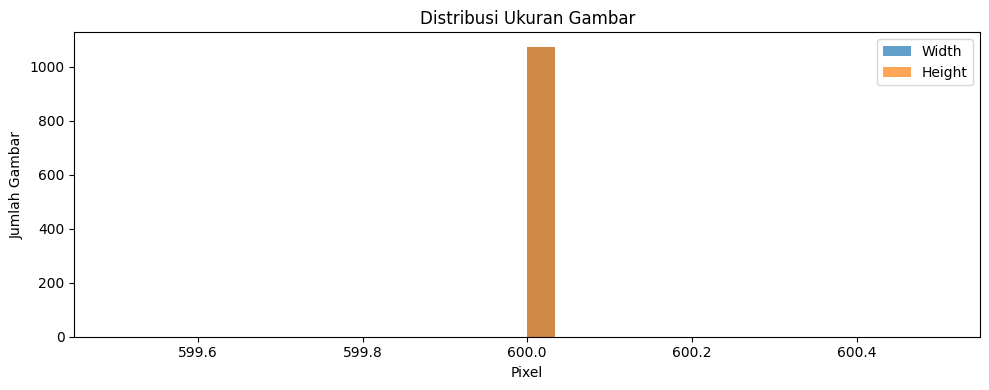

In [ ]:
# cek dimensi gambarnya
# ----------------------
dimensions = []
for path in image_files:
    try:
        with Image.open(path) as img:
            dimensions.append(img.size)  # (width, height)
    except:
        continue

# Pisahkan width dan height
widths = [w for (w, h) in dimensions]
heights = [h for (w, h) in dimensions]

plt.figure(figsize=(10, 4))
plt.hist(widths, bins=30, alpha=0.7, label='Width')
plt.hist(heights, bins=30, alpha=0.7, label='Height')
plt.title("Distribusi Ukuran Gambar")
plt.xlabel("Pixel")
plt.ylabel("Jumlah Gambar")
plt.legend()
plt.tight_layout()
plt.show()

cek dulu apakah ukuran gambarnya itu beda beda atau sama, krn kalo beda kan perlu di perbaiki

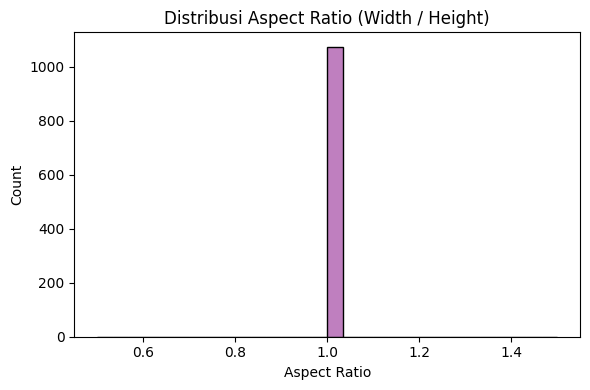

In [ ]:
# cek aspect ratio
# ----------------

aspect_ratios = [w / h for (w, h) in dimensions]

plt.figure(figsize=(6, 4))
sns.histplot(aspect_ratios, bins=30, color='purple', kde=True)
plt.title("Distribusi Aspect Ratio (Width / Height)")
plt.xlabel("Aspect Ratio")
plt.tight_layout()
plt.show()

ini untuk mencegah kalo gambar di resize dia bisa melar, nah krn hasilnya 1 jadi dia aman

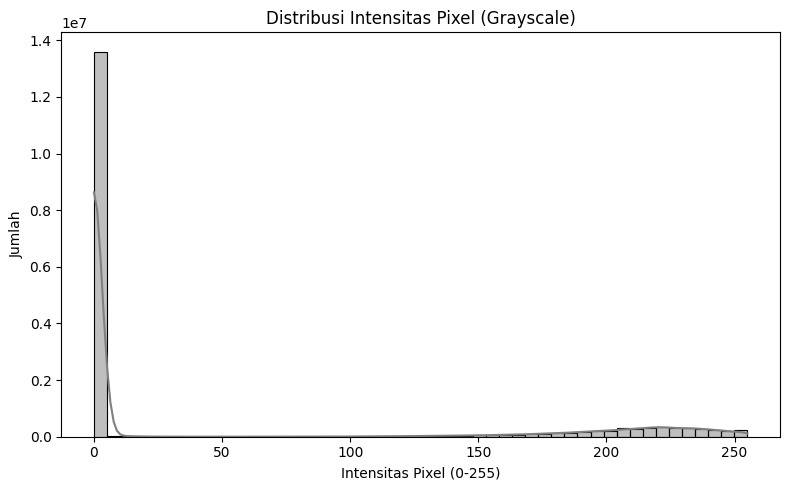

In [ ]:
# cek warna pixel gambar
# ----------------------

pixel_values = []

for path in image_files[:50]:  # ambil 50 gambar pertama biar ringan
    try:
        with Image.open(path) as img:
            gray_img = img.convert('L')  # konversi ke grayscale
            pixels = np.array(gray_img).flatten()
            pixel_values.extend(pixels)
    except:
        continue

plt.figure(figsize=(8, 5))
sns.histplot(pixel_values, bins=50, color='gray', kde=True)
plt.title('Distribusi Intensitas Pixel (Grayscale)')
plt.xlabel('Intensitas Pixel (0-255)')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

ini sebenernya untuk cek aja apakah kualitas gambarnya baik atau engga, biasa baik kalo range nya itu di tengah tengah si

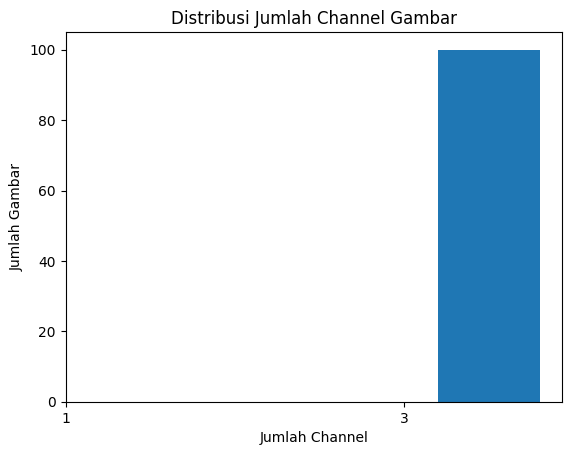

In [ ]:
# cek warna
# ----------

channel_counts = []

for path in image_files[:100]:  # ambil sebagian gambar aja
    img = cv2.imread(path)
    if img is not None:
        if len(img.shape) == 3:
            channel_counts.append(img.shape[2])
        else:
            channel_counts.append(1)

plt.hist(channel_counts, bins=[1, 2, 3, 4], rwidth=0.6)
plt.title("Distribusi Jumlah Channel Gambar")
plt.xlabel("Jumlah Channel")
plt.ylabel("Jumlah Gambar")
plt.xticks([1, 3])
plt.show()

cek apakah warna chanel nya itu udh konsisten atau blom karena kalo mau masuk ke model ya harus konsisten dulu

# b. Untuk pemodelan, anda perlu untuk membagi data menjadi 80% training, 10% validasi dan 10% testing, meresize image menjadi 100 x 100, dan membuat data yang mengandung noise sesuai ketentuan di atas


In [ ]:
from sklearn.model_selection import train_test_split

#split path gambar dulu
image_paths = image_files.copy()

#bagi 80% train, 20% (val+test)
train_paths, temp_paths = train_test_split(image_paths, test_size=0.2, random_state=42)

#bagi lagi 20% jadi 10% val, 10% test
val_paths, test_paths = train_test_split(temp_paths, test_size=0.5, random_state=42)

print("📁 Jumlah path gambar:")
print("Train:", len(train_paths))
print("Validation:", len(val_paths))
print("Test:", len(test_paths))

📁 Jumlah path gambar:
Train: 859
Validation: 107
Test: 108


In [ ]:
def load_and_preprocess_images(image_paths, size=(100, 100)):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, size)
            img = img.astype('float32') / 255.0
            images.append(img)
    return np.array(images)

X_train = load_and_preprocess_images(train_paths)
X_val = load_and_preprocess_images(val_paths)
X_test = load_and_preprocess_images(test_paths)

print("✅ Semua gambar berhasil diresize dan dinormalisasi.")

#ganti warna, resize, normalisasi pixel

✅ Semua gambar berhasil diresize dan dinormalisasi.


In [ ]:
def add_gaussian_noise(X, mean=0.0, std=0.1):
    noise = np.random.normal(mean, std, X.shape)
    X_noisy = X + noise
    return np.clip(X_noisy, 0., 1.)

X_train_noisy = add_gaussian_noise(X_train)
X_val_noisy = add_gaussian_noise(X_val)
X_test_noisy = add_gaussian_noise(X_test)

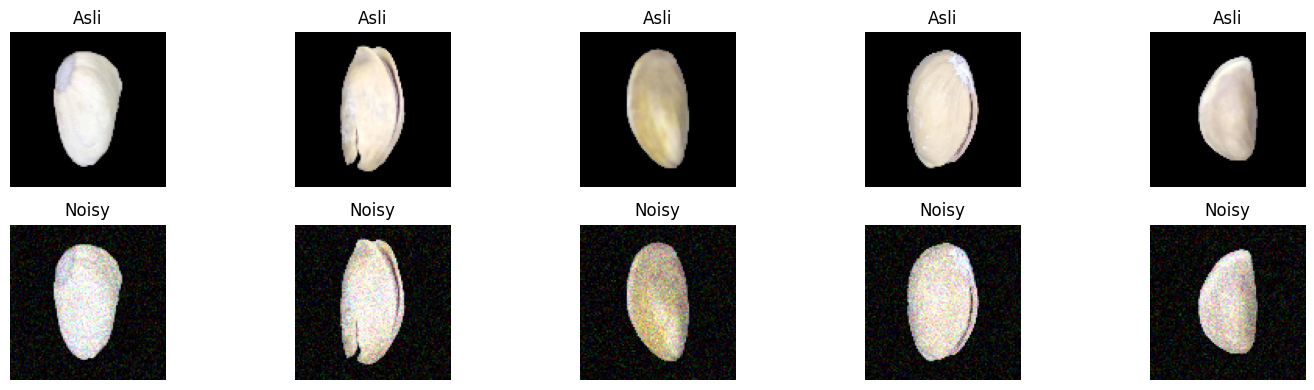

In [ ]:
# bikin noise
# -----------

import matplotlib.pyplot as plt

n = 5
plt.figure(figsize=(15, 4))
for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i])
    plt.title("Asli")
    plt.axis('off')

    plt.subplot(2, n, i + 1 + n)
    plt.imshow(X_test_noisy[i])
    plt.title("Noisy")
    plt.axis('off')
plt.tight_layout()
plt.show()

# c. Dengan semua kernel memiliki dimensi 3 x 3, fungsi aktivasi Relu, kecuali pada layer terakhir menuju output layer menggunakan Sigmoid, optimizer Adam dan loss MSE.

In [ ]:
# --------- BASELINE ------------
# -------------------------------

import tensorflow as tf
from tensorflow.keras import layers, models, Input

input_shape = (100, 100, 3)
inputs = Input(shape=input_shape)

# ----------- ENCODER -----------
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)     # (100, 100, 32)
x = layers.MaxPooling2D((2, 2), padding='same')(x)                           # (50, 50, 32)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)          # (50, 50, 32)
x = layers.MaxPooling2D((2, 2), padding='same')(x)                           # (25, 25, 64)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)          # (25, 25, 64)

# ----------- DECODER -----------
x = layers.UpSampling2D((2, 2))(x)                                           # (50, 50, 64)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)          # (50, 50, 32)

x = layers.UpSampling2D((2, 2))(x)                                           # (100, 100, 32)
outputs = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # (100, 100, 3)

# ----------- AUTOENCODER FINAL -----------
autoencoder = models.Model(inputs, outputs)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 100, 100, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,971 (187.39 KB)

 Trainable params: 47,971 (187.39 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = autoencoder.fit(
    X_train_noisy, X_train,
    epochs=30,
    batch_size=32,
    shuffle=True,
    validation_data=(X_val_noisy, X_val)
)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - loss: 0.1337 - val_loss: 0.0058
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 0.0049 - val_loss: 0.0042
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - loss: 0.0039 - val_loss: 0.0038
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0035 - val_loss: 0.0034
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0032 - val_loss: 0.0032
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0028 - val_loss: 0.0027
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - loss: 0.0025 - val_loss: 0.0025
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 0.0023 - val_loss: 0.0023
Epoch 9/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - loss: 0.0022 - val_loss: 0.0021
Epoch 10/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0020 - val_loss: 0.0021
Epoch 11/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0020 - val_loss: 0.0020
Epoch 12/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0020 - val_lo

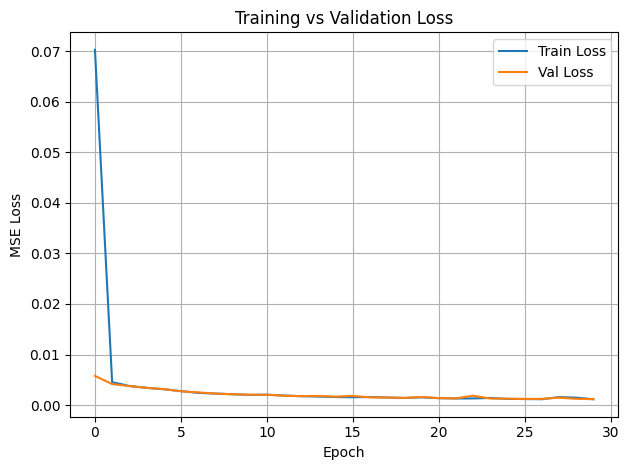

In [ ]:
#visualisasi loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


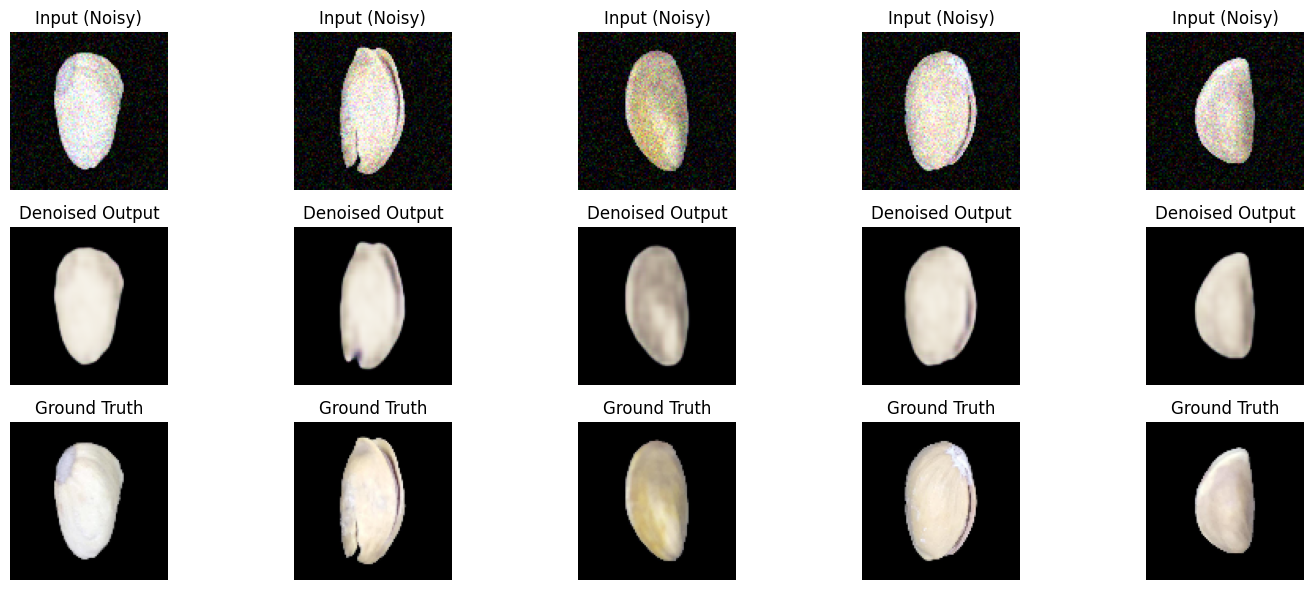

In [ ]:
#hasil auto encoder
decoded_imgs = autoencoder.predict(X_test_noisy[:5])

n = 5
plt.figure(figsize=(15, 6))
for i in range(n):
    # Input noisy
    plt.subplot(3, n, i + 1)
    plt.imshow(X_test_noisy[i])
    plt.title("Input (Noisy)")
    plt.axis('off')

    # Output denoised
    plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("Denoised Output")
    plt.axis('off')

    # Ground Truth
    plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(X_test[i])
    plt.title("Ground Truth")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# --------- MODIFIKASI ----------
# -------------------------------

input_shape = (100, 100, 3)
inputs = Input(shape=input_shape)

# ----------- ENCODER -----------
x = layers.Conv2D(32, (3, 3), strides=(2, 2), activation='relu', padding='same')(inputs)  # (50x50x32)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)       # (25x25x64)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)                      # (25x25x128)

# ----------- DECODER -----------
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)                                                        # (50x50x64)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)                                                        # (100x100x32)

outputs = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# ----------- FINAL MODEL -----------
improved_autoencoder = models.Model(inputs, outputs)
improved_autoencoder.compile(optimizer='adam', loss='mse')
improved_autoencoder.summary()

#pake stride, pke batch normalization, digedein chanelnya

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 25, 25, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 100, 100, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,755 (729.51 KB)

 Trainable params: 186,563 (728.76 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
history_mod = improved_autoencoder.fit(
    X_train_noisy, X_train,
    epochs=30,
    batch_size=32,
    shuffle=True,
    validation_data=(X_val_noisy, X_val)
)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 0.0470 - val_loss: 0.0588
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 0.0046 - val_loss: 0.0281
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0032 - val_loss: 0.0256
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0024 - val_loss: 0.0289
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 0.0023 - val_loss: 0.0288
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - loss: 0.0022 - val_loss: 0.0279
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 0.0018 - val_loss: 0.0257
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0017 - val_loss: 0.0238
Epoch 9/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0015 - val_loss: 0.0206
Epoch 10/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - loss: 0.0014 - val_loss: 0.0164
Epoch 11/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0014 - val_loss: 0.0160
Epoch 12/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 0.0014 - val_lo

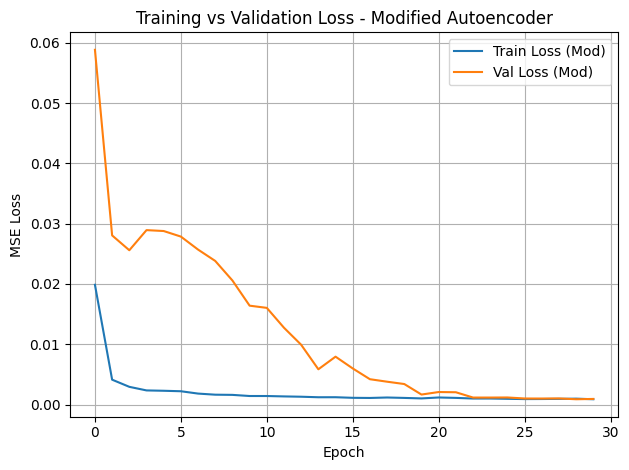

In [ ]:
plt.plot(history_mod.history['loss'], label='Train Loss (Mod)')
plt.plot(history_mod.history['val_loss'], label='Val Loss (Mod)')
plt.title('Training vs Validation Loss - Modified Autoencoder')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#ukur kemiripan data asli sama predicted

from skimage.metrics import structural_similarity as ssim

def calculate_average_ssim(original, predicted):
    scores = []
    for i in range(len(original)):
        #ubah ke grayscale dulu biar fair dan ringan
        original_gray = np.mean(original[i], axis=2)
        predicted_gray = np.mean(predicted[i], axis=2)
        score = ssim(original_gray, predicted_gray, data_range=1.0)
        scores.append(score)
    return np.mean(scores)

In [ ]:
baseline_preds = autoencoder.predict(X_test_noisy)
mod_preds = improved_autoencoder.predict(X_test_noisy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 331ms/step


In [ ]:
ssim_baseline = calculate_average_ssim(X_test, baseline_preds)
ssim_mod = calculate_average_ssim(X_test, mod_preds)

print(f"📈 SSIM Baseline Autoencoder: {ssim_baseline:.4f}")
print(f"🛠️ SSIM Modified Autoencoder: {ssim_mod:.4f}")

📈 SSIM Baseline Autoencoder: 0.9444
🛠️ SSIM Modified Autoencoder: 0.9520


Setelah aku coba bandingin, ternyata model yang udah dimodifikasi hasilnya lebih bagus dari yang baseline, walaupun sebenernya model baseline nya juga udah cukup bagus. Aku lihat dari nilai SSIM-nya, yang baseline dapet 0.9444 sedangkan yang udah dimodifikasi naik jadi 0.9520. Artinya, gambar hasil model yang dimodifikasi itu lebih mirip sama gambar aslinya. Jadi bisa dibilang, perubahan arsitektur yang aku lakuin dengan nambahin batch normalization dan conv layer berhasil bikin model lebih akurat dalam “memperbaiki” gambar yang ada noise-nya.